## Import necessary modules

We begin by importing all necessary modules. The install function can be used to install the uninstalled modules.

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../src'))
from utils import * 
import pandas as pd
import psycopg2
from sqlalchemy import create_engine, text
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score, adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import gmean
from skbio.stats.composition import ilr
import seaborn as sns

## Conect to PosgreSQL and import data

In [2]:
# PostgreSQL connection info
username = "postgres"  # or your PostgreSQL username
password = "1234"
host = "localhost"           # or e.g. "127.0.0.1"
port = "5432"                # default port
database = "energy_forecast"  # or your database name

# Create connection engine
engine = create_engine(f"postgresql+psycopg2://{username}:{password}@{host}:{port}/{database}")
conn = engine.connect()
result = conn.execute(text("SELECT * FROM public.generation_data where EXTRACT(YEAR FROM \"DATETIME\") < 2025;"))
data = pd.DataFrame(result.fetchall()).set_index('DATETIME')
print(data.info())

# Convert from MW to GWh
for col in data.columns:
    if 'perc' not in col:
        data[col] = data[col] / 2 / 1000

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280512 entries, 2009-02-02 04:00:00 to 2024-12-24 16:00:00
Data columns (total 33 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CARBON_INTENSITY  280512 non-null  float64
 1   NUCLEAR           280512 non-null  float64
 2   STORAGE           280512 non-null  float64
 3   LOW_CARBON        280512 non-null  float64
 4   HYDRO             280512 non-null  float64
 5   WIND_EMB          280512 non-null  float64
 6   IMPORTS           280512 non-null  float64
 7   GAS               280512 non-null  float64
 8   COAL              280512 non-null  float64
 9   FOSSIL            280512 non-null  float64
 10  GENERATION        280512 non-null  float64
 11  OTHER             280512 non-null  float64
 12  ZERO_CARBON       280512 non-null  float64
 13  BIOMASS           280512 non-null  float64
 14  WIND              280512 non-null  float64
 15  SOLAR             280512 non-null 

<BarContainer object of 16 artists>

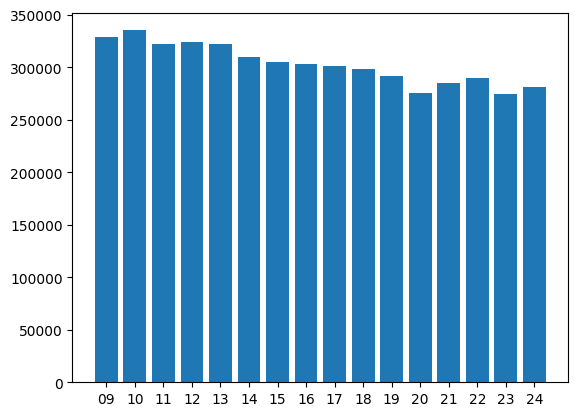

In [3]:
data_yearly = data.groupby(data.index.to_period('Y')).sum() # The data is in half-hourly intervals
data_yearly.set_index(data_yearly.index.to_timestamp(), inplace=True)
data_yearly.index.name = 'Date'
plt.bar(data_yearly.index.strftime('%y'), data_yearly['GENERATION'], label='Generation')

## Pre-process
1. Combine wind and embedded wind.
2. I include only "percentage" data as the level of generation should increases overtime due to the increase in power demand. I am interested in the change in the composition of different generation methods.
3. I remove some aggregate columns since some of them overlap, e.g., Wind is included in Renewable, Zero carbon and low carbon.
4. I create two types of generation types, individual and grouped. Each individual type contains only one generation method, while grouped types may contain more than 1, e.g., Renewable = Wind + Wind_Emb + Solar + Hydro.

In [4]:
data['WIND'] += data['WIND_EMB']
data['WIND_perc'] += data['WIND_EMB_perc']
data.drop(columns=['WIND_EMB', 'WIND_EMB_perc'], inplace=True)
print(data.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 280512 entries, 2009-02-02 04:00:00 to 2024-12-24 16:00:00
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   CARBON_INTENSITY  280512 non-null  float64
 1   NUCLEAR           280512 non-null  float64
 2   STORAGE           280512 non-null  float64
 3   LOW_CARBON        280512 non-null  float64
 4   HYDRO             280512 non-null  float64
 5   IMPORTS           280512 non-null  float64
 6   GAS               280512 non-null  float64
 7   COAL              280512 non-null  float64
 8   FOSSIL            280512 non-null  float64
 9   GENERATION        280512 non-null  float64
 10  OTHER             280512 non-null  float64
 11  ZERO_CARBON       280512 non-null  float64
 12  BIOMASS           280512 non-null  float64
 13  WIND              280512 non-null  float64
 14  SOLAR             280512 non-null  float64
 15  RENEWABLE         280512 non-null 

In [5]:
aggregate_cols = ['RENEWABLE', 'FOSSIL', 'ZERO_CARBON', 'LOW_CARBON', 'GENERATION', 'DATETIME', 'CARBON_INTENSITY']
generation = [col for col in data.columns if col not in aggregate_cols and '_perc' not in col] # perc from index 18
generation_perc = [col + '_perc' for col in generation]
print(f'sum of individual generation type ({len(generation_perc)}): {data[generation_perc].sum(axis=1).mean(axis=0)}')

generation_group = ['RENEWABLE', 'FOSSIL', 'NUCLEAR', 'STORAGE', 'BIOMASS', 'IMPORTS', 'OTHER']
generation_group_perc = [col + '_perc' for col in generation_group]
print(f'sum of grouped generation type ({len(generation_group_perc)}): {data[generation_group_perc].sum(axis=1).mean(axis=0)}')

sum of individual generation type (10): 99.99909023499887
sum of grouped generation type (7): 100.71774469541408


# clustering analysis
## Data choice:
- My goal is to find the structural change in UK generation mix from 2009 to 2024. The higher frequency data is not suitable for this analysis due to the irregularity of the data, which creates noise to the clustering analysis. For example, the low-wind data points in different years may be classified as the same clusters. However, I still perform the analysis for reference (analysis 1 and 2 below).


## Feature choice:
I first choose the features to be individual or grouped generation type.
- generation: individual generation source.
- generation_group: grouped generation source.

In [6]:
cols = generation

## 1. Half-hourly data
- The maximum number of clusters is 5. As the total years in the sample are only 16 years, 5 clusters indicates, averagely, 1 structure change per 3 years. Higher than 5 clusters is less unlikely to happen since developing power generation infrastructure is time-consuming.
- The optimal number of clusters is chosen based on Davies Bouldin Index. The lower index value suggests the lower similarity between clusters.

In [7]:
X = data[cols]
kmeans_model, labels, db_scores = [], [], []
for n_cluster in range(2, 6):
    kmeans = cluster_analysis(X, n_cluster)
    kmeans_model.append(kmeans[0])
    labels.append(kmeans[1])
    db_scores.append(kmeans[2])

optimal_n_clusters = db_scores.index(min(db_scores)) + 2
print(f'Optimal number of clusters: {optimal_n_clusters} with Davies-Bouldin score: {db_scores[optimal_n_clusters - 2]}')

n_cluster:2, db_score:1.1022
n_cluster:3, db_score:1.0958
n_cluster:4, db_score:1.0593
n_cluster:5, db_score:1.1682
Optimal number of clusters: 4 with Davies-Bouldin score: 1.0593


The optimal number of clusters is 4 according to Davies Bouldin Index. I draw the renewable generation percentage below along with their clusters below. It appears a time break around 2016 where the blue cluster disappears but the yeller cluster appears. However, the seperation between the grey and the light brown clusters is ambigious. This is like due to the intradaily pattern of the generation sources, i.e., no solar generation at night.

(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Clustering Chart'}>)

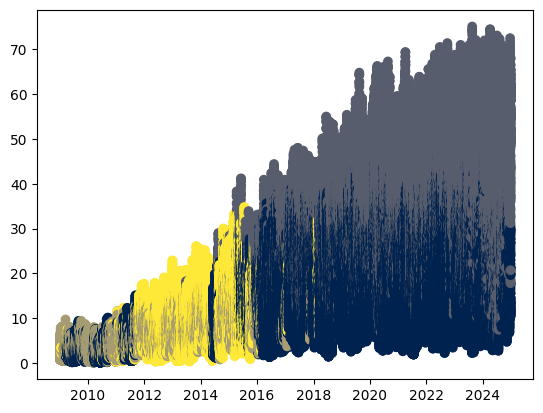

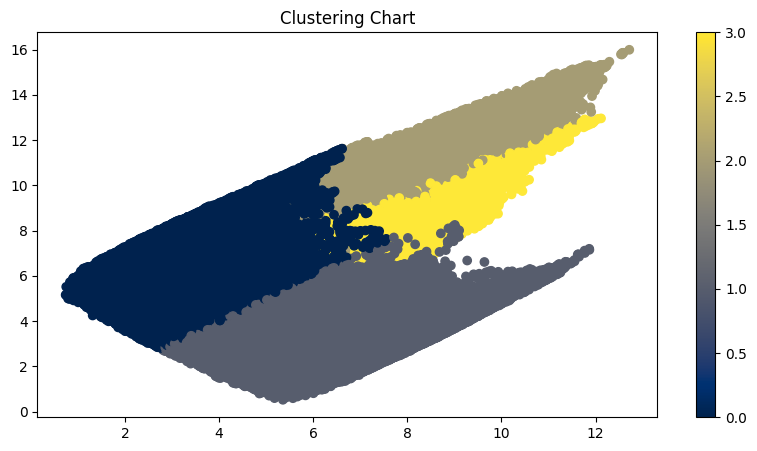

In [8]:
optimal_label = labels[optimal_n_clusters - 2]
plt.scatter(data.index, data['RENEWABLE_perc'], c=optimal_label, cmap='cividis')
clustering_chart(X, kmeans_model[optimal_n_clusters - 2], optimal_label)

## 2. Daily data

Daily data is the sum of all half-hourly data within a day. The optimal number clusters is chosen by Davies Bouldin Index.

In [9]:
# Prepare the daily data for clustering
data_daily = data.groupby(data.index.to_period('D')).sum()
data_daily.set_index(data_daily.index.to_timestamp(), inplace=True)
data_daily.index.name = 'Date'
data_daily = data_daily[[col.upper() for col in cols]]

In [10]:
X = data_daily
kmeans_model, labels, db_scores = [], [], []
for n_cluster in range(2, 6):
    kmeans = cluster_analysis(X, n_cluster)
    kmeans_model.append(kmeans[0])
    labels.append(kmeans[1])
    db_scores.append(kmeans[2])
    
optimal_n_clusters = db_scores.index(min(db_scores)) + 2
print(f'Optimal number of clusters: {optimal_n_clusters} with Davies-Bouldin score: {db_scores[optimal_n_clusters - 2]}')

n_cluster:2, db_score:0.9755
n_cluster:3, db_score:0.9913
n_cluster:4, db_score:1.0342
n_cluster:5, db_score:1.1908
Optimal number of clusters: 2 with Davies-Bouldin score: 0.9755


(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Clustering Chart'}>)

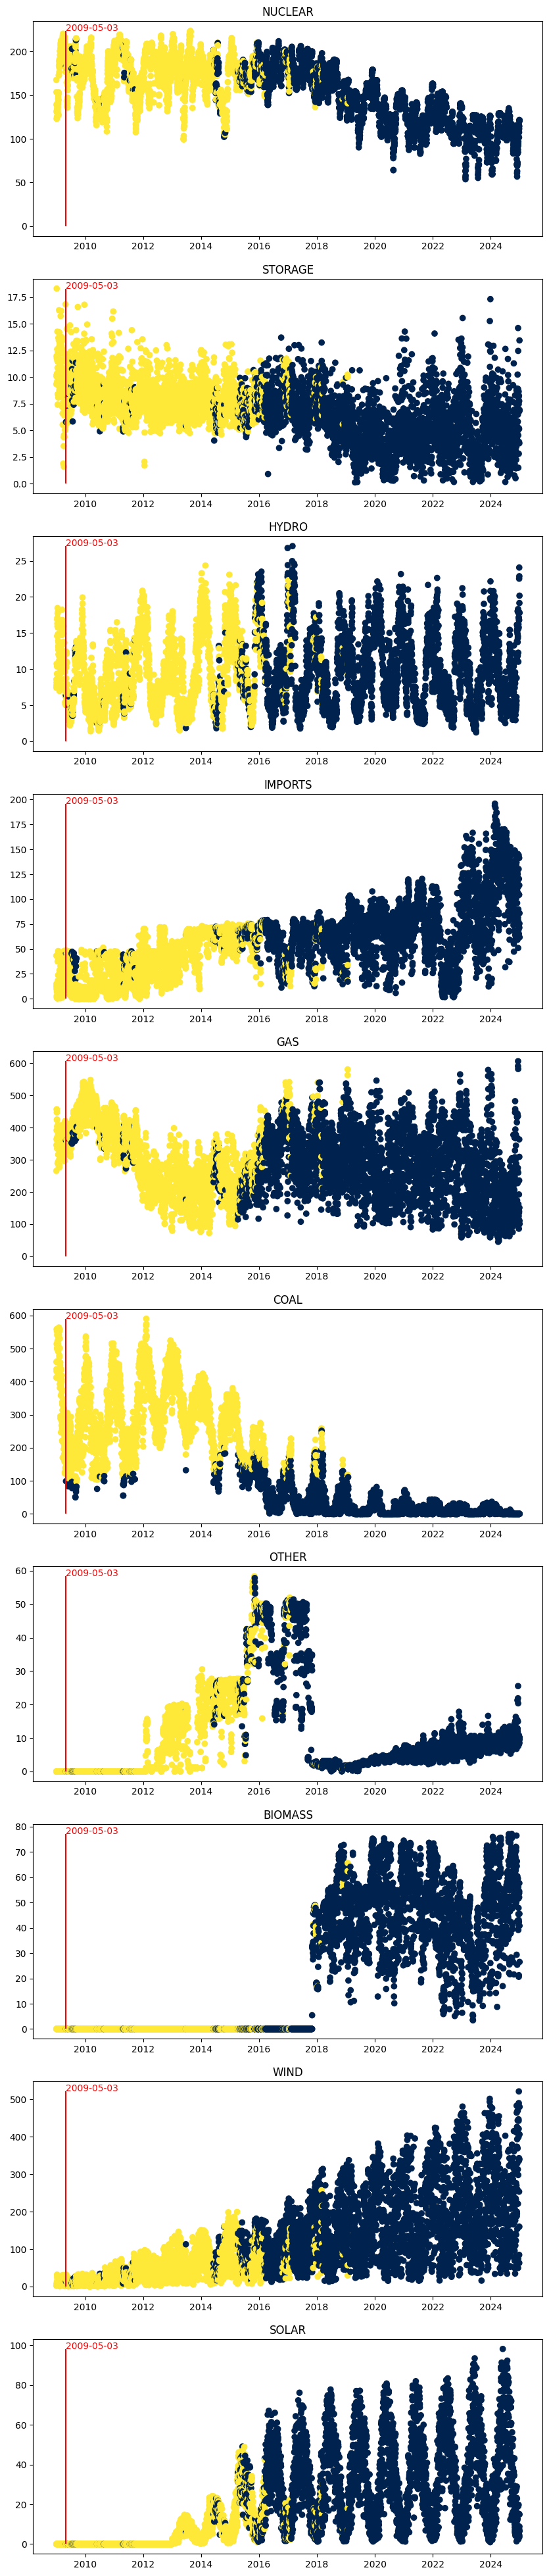

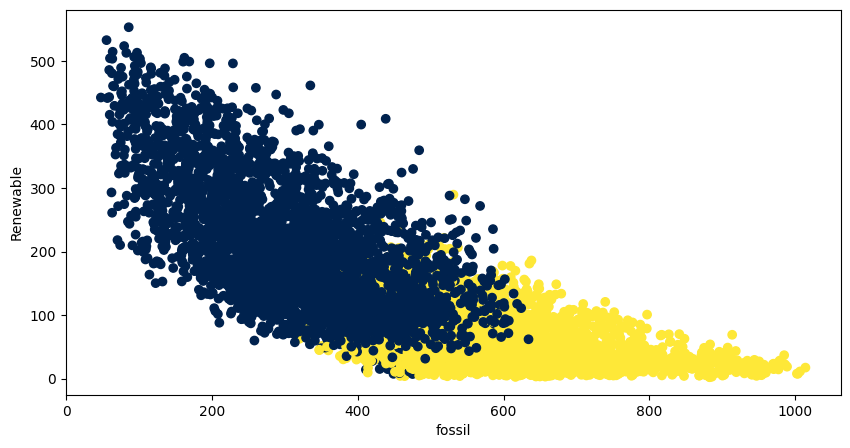

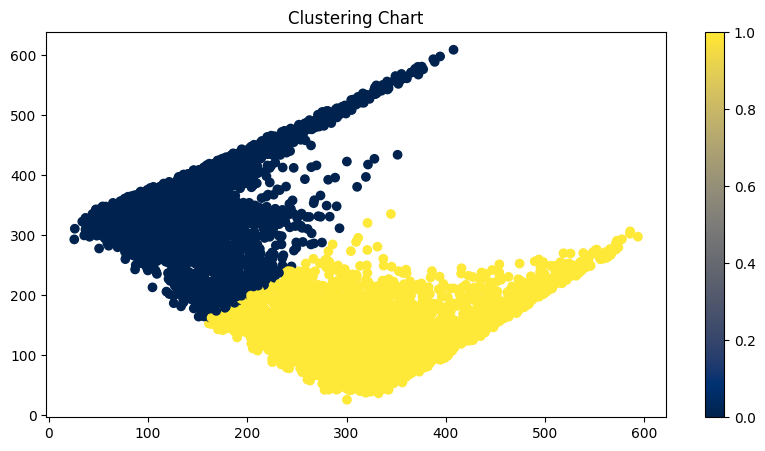

In [11]:
optimal_label = labels[optimal_n_clusters - 2]
detailed_chart(data_daily, cols, optimal_label, timeformat='%Y-%m-%d')
focus_chart(data_daily, optimal_label)
clustering_chart(X, kmeans_model[optimal_n_clusters - 2], optimal_label)

The optimal number cluster with daily data is 2. The over-time coal chart shows an subtle seperation at 100 - 200 GWh levels. However, the seperation in other generation sources, e.g. Wind and Solar is ambiguous. Again, this may be due to the nature of variation in renewable genearion.

## 3. monthly data
Before proceeding the clustering analysis with monthly data, I investigate the seasonality issue according to the previous observation in previous two clustering analyses.

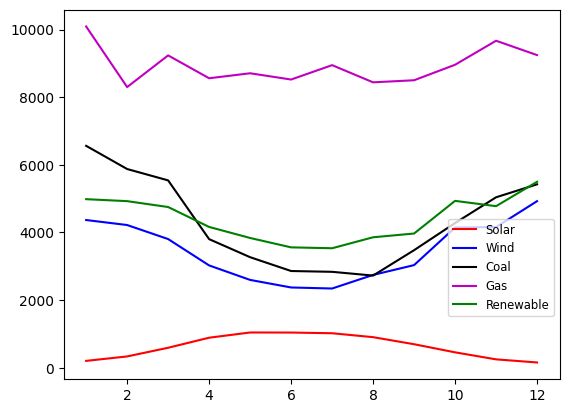

In [12]:
data_monthly = data.groupby(data.index.to_period('M')).sum()
data_monthly.set_index(data_monthly.index.to_timestamp(), inplace=True)
data_monthly.index.name = 'Date'
data_monthly = data_monthly[[col.upper() for col in cols]]

data_monthly_avg = data_monthly.groupby(data_monthly.index.month).mean()
data_monthly_avg.index.name = 'Month'

plt.plot(data_monthly_avg.index, data_monthly_avg['SOLAR'], label='Solar', c='r')
plt.plot(data_monthly_avg.index, data_monthly_avg['WIND'], label='Wind', c='b')
plt.plot(data_monthly_avg.index, data_monthly_avg['COAL'], label='Coal', c='k')
plt.plot(data_monthly_avg.index, data_monthly_avg['GAS'], label='Gas', c='m')
plt.plot(data_monthly_avg.index, data_monthly_avg[['WIND', 'SOLAR', 'HYDRO']].sum(axis=1), label='Renewable', c='g')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.45), fontsize='small')

The chart shows a clear seasonality in solar, wind, coal generation, and the relation between them is interesting. 

Despite both being renewable resources, solar generation peaks in summer while wind generation reaches higher levels in winter. As a result, the seasonality in total renewable becomes less strong (green line).

Coal is used to help when the solar power lacks. As the monthly seasonality exist, it is worthwhile to deseason the data and do another clustering analysis.

After confirming the seasonality, I deseason the monthly generation mix first before running the clustering analysis.

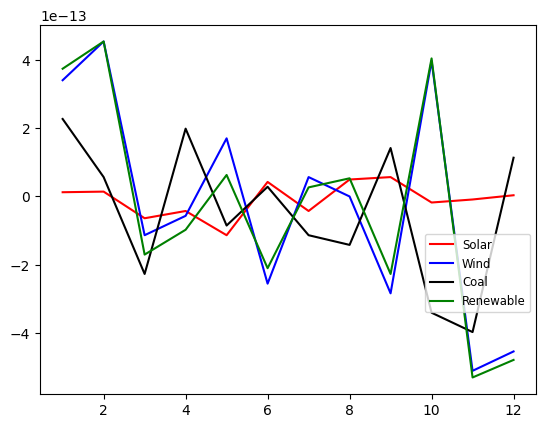

In [13]:
data_monthly_deseasoned = data_monthly.copy()
for idx in data_monthly_deseasoned.index:
    month = idx.month
    data_monthly_deseasoned.loc[idx] = data_monthly_deseasoned.loc[idx] - data_monthly_avg.loc[month]

data_monthly_avg_deseasoned = data_monthly_deseasoned.groupby(data_monthly_deseasoned.index.month).mean()
data_monthly_avg_deseasoned.index.name = 'Month'

plt.plot(data_monthly_avg_deseasoned.index, data_monthly_avg_deseasoned['SOLAR'], label='Solar', c='r')
plt.plot(data_monthly_avg_deseasoned.index, data_monthly_avg_deseasoned['WIND'], label='Wind', c='b')
plt.plot(data_monthly_avg_deseasoned.index, data_monthly_avg_deseasoned['COAL'], label='Coal', c='k')
plt.plot(data_monthly_avg_deseasoned.index, data_monthly_avg_deseasoned[['WIND', 'SOLAR', 'HYDRO']].sum(axis=1), label='Renewable', c='g')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.45), fontsize='small')


Now, I run the analysis with deseasoned monthly data.

n_cluster:2, db_score:0.7146
n_cluster:3, db_score:0.9571
n_cluster:4, db_score:0.9266
n_cluster:5, db_score:0.901
Optimal number of clusters: 2 with Davies-Bouldin score: 0.7146


(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Clustering Chart'}>)

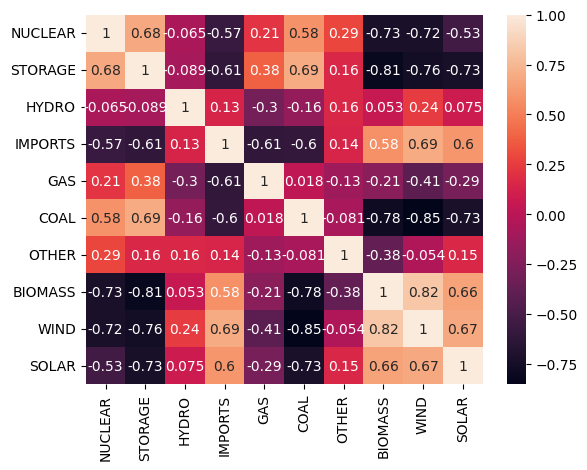

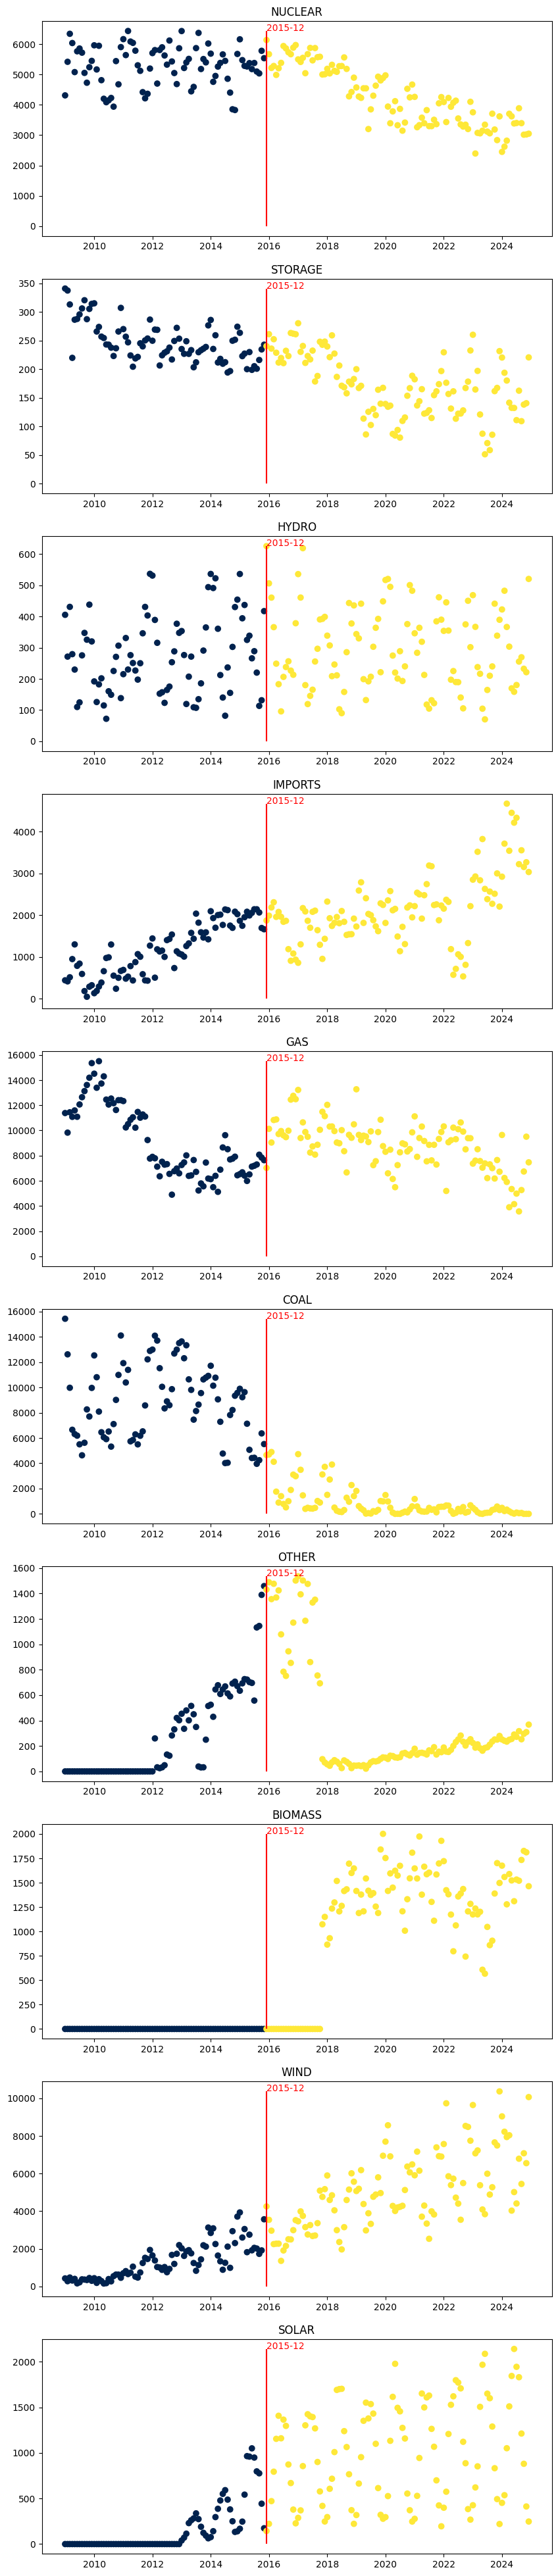

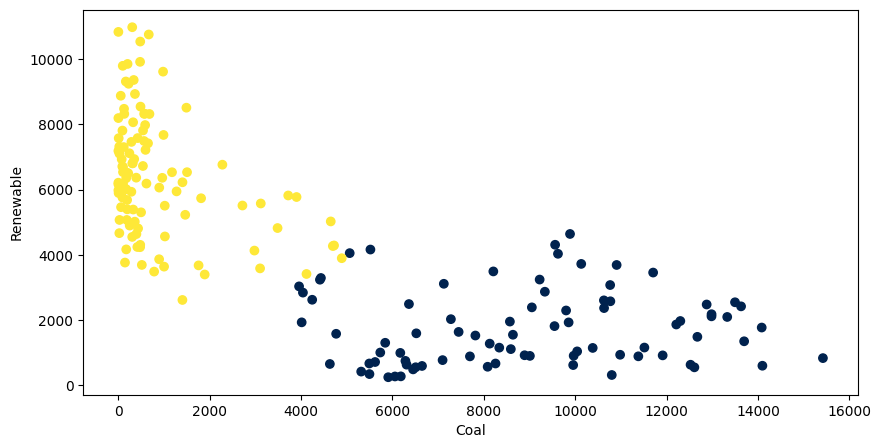

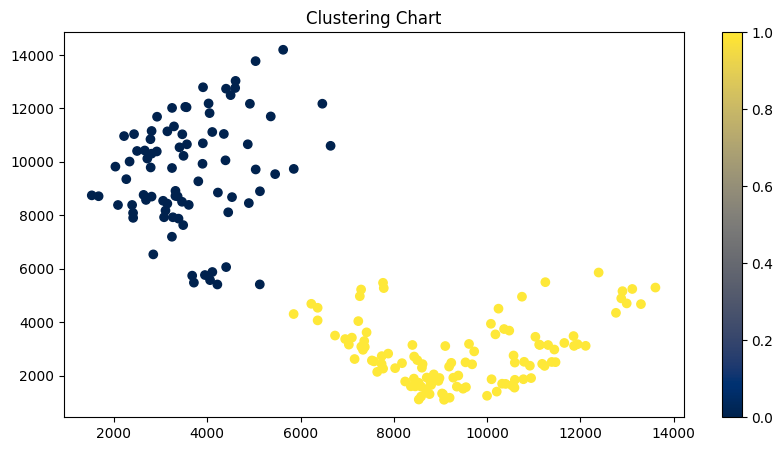

In [14]:
X = data_monthly_deseasoned
sns.heatmap(X.corr(), annot=True)

kmeans_model, labels, db_scores = [], [], []
for n_cluster in range(2, 6):
    kmeans = cluster_analysis(X, n_cluster)
    kmeans_model.append(kmeans[0])
    labels.append(kmeans[1])
    db_scores.append(kmeans[2])

optimal_n_clusters = db_scores.index(min(db_scores)) + 2
print(f'Optimal number of clusters: {optimal_n_clusters} with Davies-Bouldin score: {db_scores[optimal_n_clusters - 2]}')

optimal_label = labels[optimal_n_clusters - 2]

detailed_chart(data_monthly, cols, optimal_label, timeformat='%Y-%m')
focus_chart(data_monthly, optimal_label, col1=['COAL'], col1_name='Coal')
clustering_chart(X, kmeans_model[optimal_n_clusters - 2], optimal_label)

The analysis with the deseasoned monthly data shows the optimal number of clusters is 2, and there is a clear seperation at 4000 GWh coal generation and 3000 - 3500 GWh renewable generation (yellow). The temporal division is clear and neat in December 2015, which is right after the UK government annouced plan to close coal power stations by 2025.

## 4. Yearly data
Finally, I analyse the yearly data. As the total number of sample are only 15 years, it creates some chanllenges to perform the clustering analysis. Hence, I include the following to enhance the robustness of the analysis.
- I set n_init and max_iter higher to 100 and 1000 respectively.
- I include sihuouette score as an additional reference to determine the optimal number of clusters.
- I perform a stability test with Bootstrap samples (200 randomly selected sample).

In [15]:
data_yearly = data_yearly[[col.upper() for col in cols]]

X = data_yearly
kmeans_model, labels, db_scores, sh_scores = [], [], [], []
for n_cluster in range(2, 5):
    kmeans = cluster_analysis(X, n_cluster, n_init=100, max_iter=1000, stab=True, silhouette=True)
    kmeans_model.append(kmeans[0])
    labels.append(kmeans[1])
    db_scores.append(kmeans[2])
    sh_scores.append(kmeans[3])

optimal_n_clusters = db_scores.index(min(db_scores)) + 2
print(f'Optimal number of clusters: {optimal_n_clusters} with Davies-Bouldin score: {db_scores[optimal_n_clusters - 2]}')

n_cluster:2, db_score:0.5932, silhouette_score:0.5916
stability:0.9928
n_cluster:3, db_score:0.5386, silhouette_score:0.5956
stability:0.8672
n_cluster:4, db_score:0.6272, silhouette_score:0.4708
stability:0.8053
Optimal number of clusters: 3 with Davies-Bouldin score: 0.5386


(<Figure size 1000x500 with 2 Axes>,
 <Axes: title={'center': 'Clustering Chart'}>)

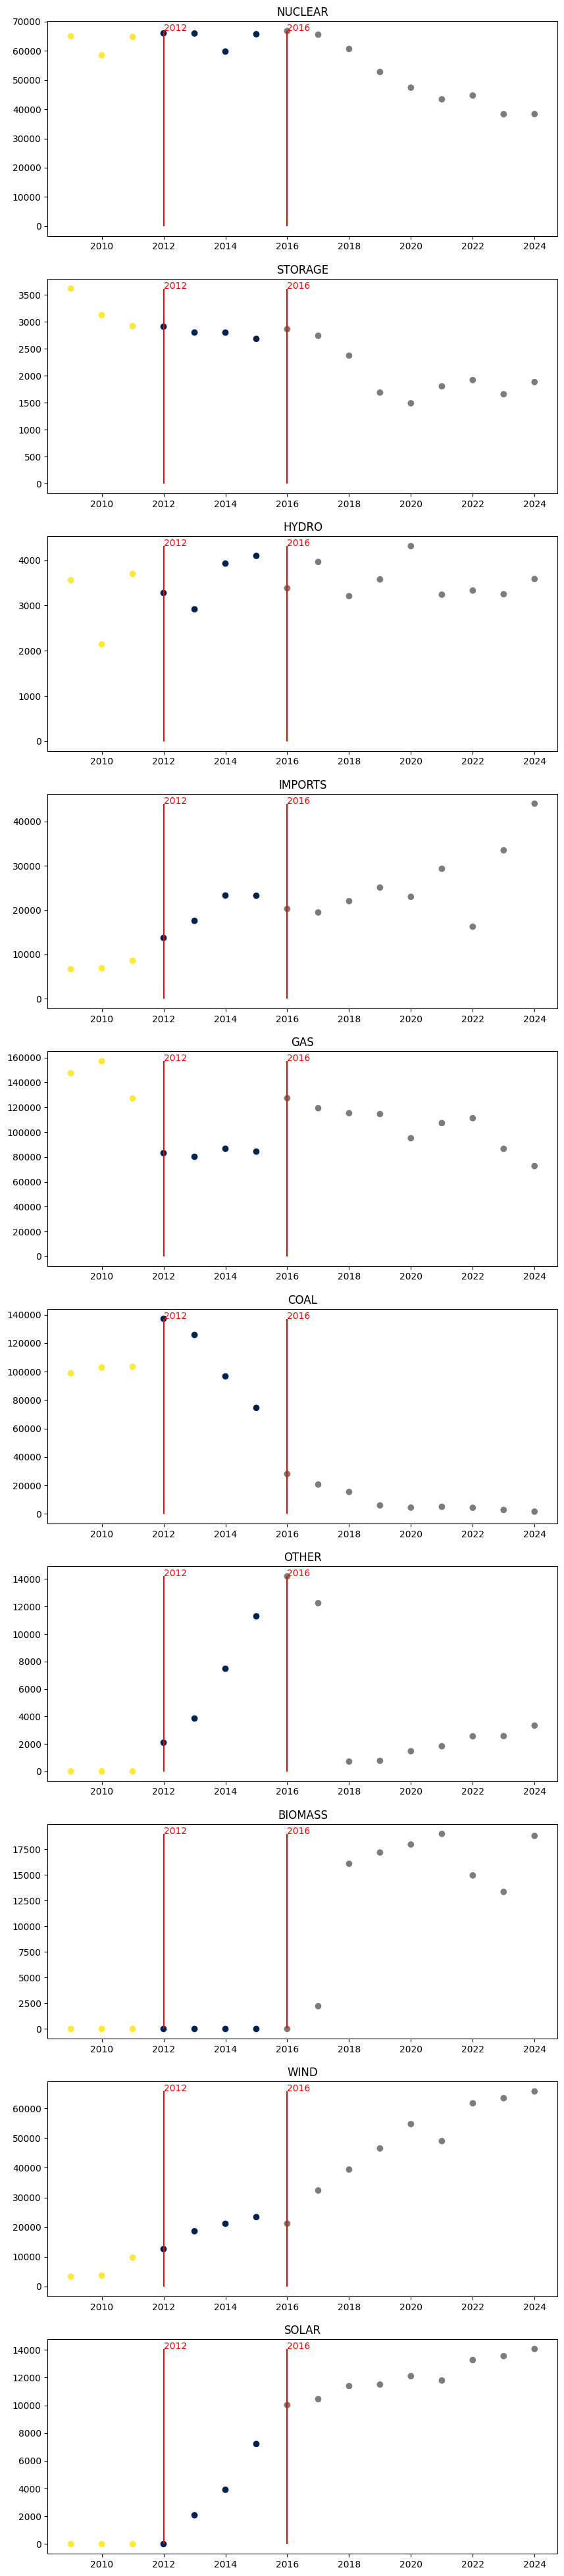

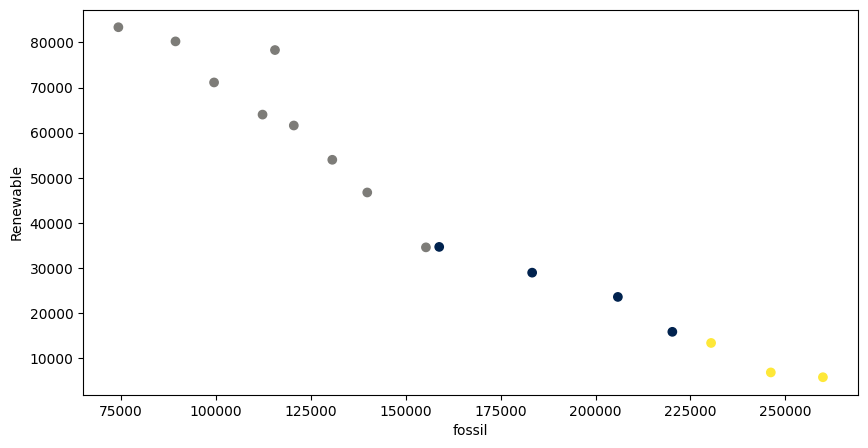

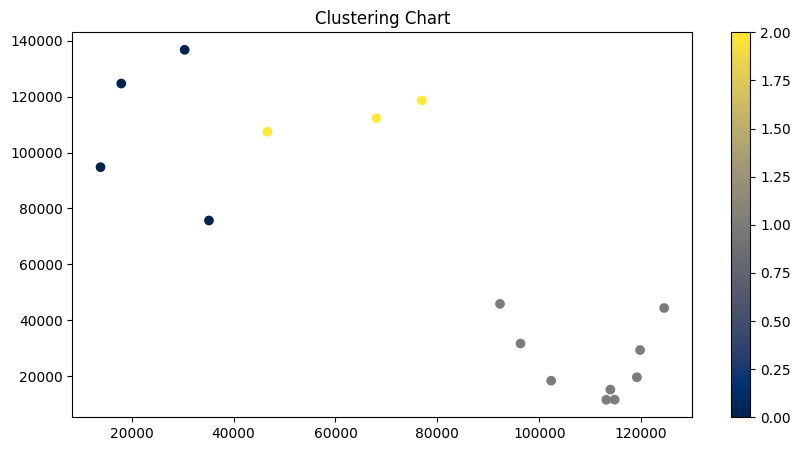

In [16]:
optimal_label = labels[optimal_n_clusters - 2]
detailed_chart(data_yearly, cols, optimal_label, timeformat='%Y')
focus_chart(data_yearly, optimal_label)
clustering_chart(X, kmeans_model[optimal_n_clusters - 2], optimal_label)

The optimal number of clusters is chosen to be 3. The seperation in 2016 echos the result with the deseasoned monthly data when coal generation largely reduced. In the yearly view, I also observe the Wind generation doubles in 2024 compared to its 2016 level.

The additional division happened in 2012, where coal had a sharp increase follwed by a steep decrease and solar started to grow.

With the scatter chart between fossil and renewable generation, the changes in generation mix becomes clear and can be summarised as follows:
1. Before 2012: The generation was dominated by fossil fuels with more than 225k GWh yearly generation.
2. Between 2012 and 2016: The fossil fuels gradually reduced from 220k GWh/year to around 160k GWh/year. The renewable generation slowly grew in this period.
3. After 2016: The fossil fuel has largely decreased, especially coal. The renewable generation has fastly grown with the double wind generation.